In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapley_sampling import SamplingExplainerTF
from path_explain import utils, scatter_plot, summary_plot

In [3]:
utils.set_up_environment(visible_devices='0')

In [4]:
n = 5000
d = 5
noise = 0.5
X = np.random.randn(n, d)
y = np.sum(X, axis=-1) + 2 * np.prod(X[:, 0:2], axis=-1)

In [5]:
threshold = int(n * 0.8)
X_train = X[:threshold]
y_train = y[:threshold]
X_test  = X[threshold:]
y_test  = y[threshold:]

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(d,)))
model.add(tf.keras.layers.Dense(units=10,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=5,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,
                                use_bias=False,
                                activation=None))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [8]:
learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.MeanSquaredError())

In [9]:
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=2, validation_split=0.8)

Train on 799 samples, validate on 3201 samples
Epoch 1/20
799/799 - 1s - loss: 8.5372 - val_loss: 5.8078
Epoch 2/20
799/799 - 0s - loss: 4.6959 - val_loss: 2.7289
Epoch 3/20
799/799 - 0s - loss: 3.7328 - val_loss: 2.0947
Epoch 4/20
799/799 - 0s - loss: 1.8119 - val_loss: 0.8661
Epoch 5/20
799/799 - 0s - loss: 1.3304 - val_loss: 3.6915
Epoch 6/20
799/799 - 0s - loss: 0.7753 - val_loss: 0.4598
Epoch 7/20
799/799 - 0s - loss: 2.0733 - val_loss: 0.3761
Epoch 8/20
799/799 - 0s - loss: 0.6667 - val_loss: 0.3662
Epoch 9/20
799/799 - 0s - loss: 0.5221 - val_loss: 0.6424
Epoch 10/20
799/799 - 0s - loss: 0.4588 - val_loss: 0.2568
Epoch 11/20
799/799 - 0s - loss: 0.4425 - val_loss: 0.1611
Epoch 12/20
799/799 - 0s - loss: 0.3400 - val_loss: 0.2089
Epoch 13/20
799/799 - 0s - loss: 0.4785 - val_loss: 0.2157
Epoch 14/20
799/799 - 0s - loss: 0.2747 - val_loss: 0.1792
Epoch 15/20
799/799 - 0s - loss: 0.3683 - val_loss: 0.1861
Epoch 16/20
799/799 - 0s - loss: 0.2413 - val_loss: 0.1634
Epoch 17/20
799/79

In [10]:
model.evaluate(X_test, y_test, batch_size=50, verbose=2)

1000/1000 - 0s - loss: 0.1322


0.13215181622654198

In [11]:
y_test_pred = model.predict(X_test, batch_size=50)

In [12]:
df = pd.DataFrame({
    'Predicted Outcome': y_test_pred[:, 0],
    'True Outcome': y_test
})

In [13]:
def scatterplot(x, y, df, title=None):
    fig = plt.figure(dpi=100)
    ax = fig.gca()
    ax.scatter(df[x],
               df[y],
               s=10)
    ax.grid(linestyle='--')
    ax.set_axisbelow(True)
    ax.set_xlabel(x, fontsize=11)
    ax.set_ylabel(y, fontsize=11)
    ax.spines['top'].set_linewidth(0.1)
    ax.spines['right'].set_linewidth(0.1)
    ax.set_title(title)

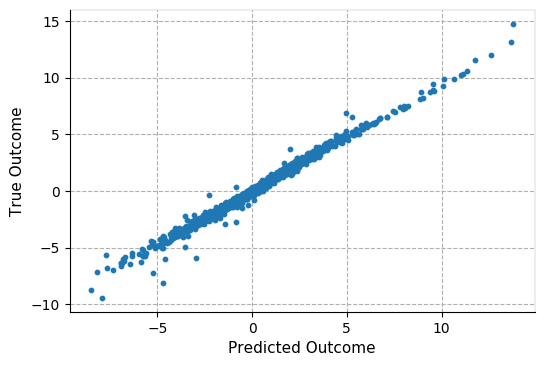

In [14]:
scatterplot('Predicted Outcome', 'True Outcome', df)

In [15]:
explainer = SamplingExplainerTF(model)

In [16]:
feature_values = X_test

In [17]:
attributions = explainer.attributions(inputs=feature_values.astype(np.float32),
                                      baselines=np.zeros(d),
                                      batch_size=50,
                                      number_of_samples=50,
                                      output_index=None,
                                      verbose=False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [18]:
interactions = explainer.interactions(inputs=feature_values.astype(np.float32),
                                      baselines=np.zeros(d),
                                      batch_size=50,
                                      number_of_samples=50,
                                      output_index=None,
                                      verbose=False)

In [19]:
data_df = pd.DataFrame({
    'Product': 2 * np.prod(feature_values[:, 0:2], axis=-1),
    'Interaction': interactions[:, 0, 1]
})

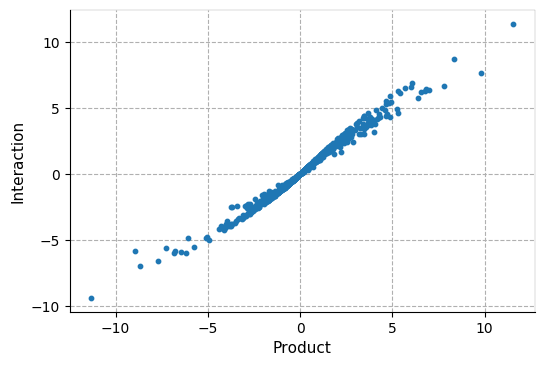

In [20]:
scatterplot('Product', 'Interaction', data_df)

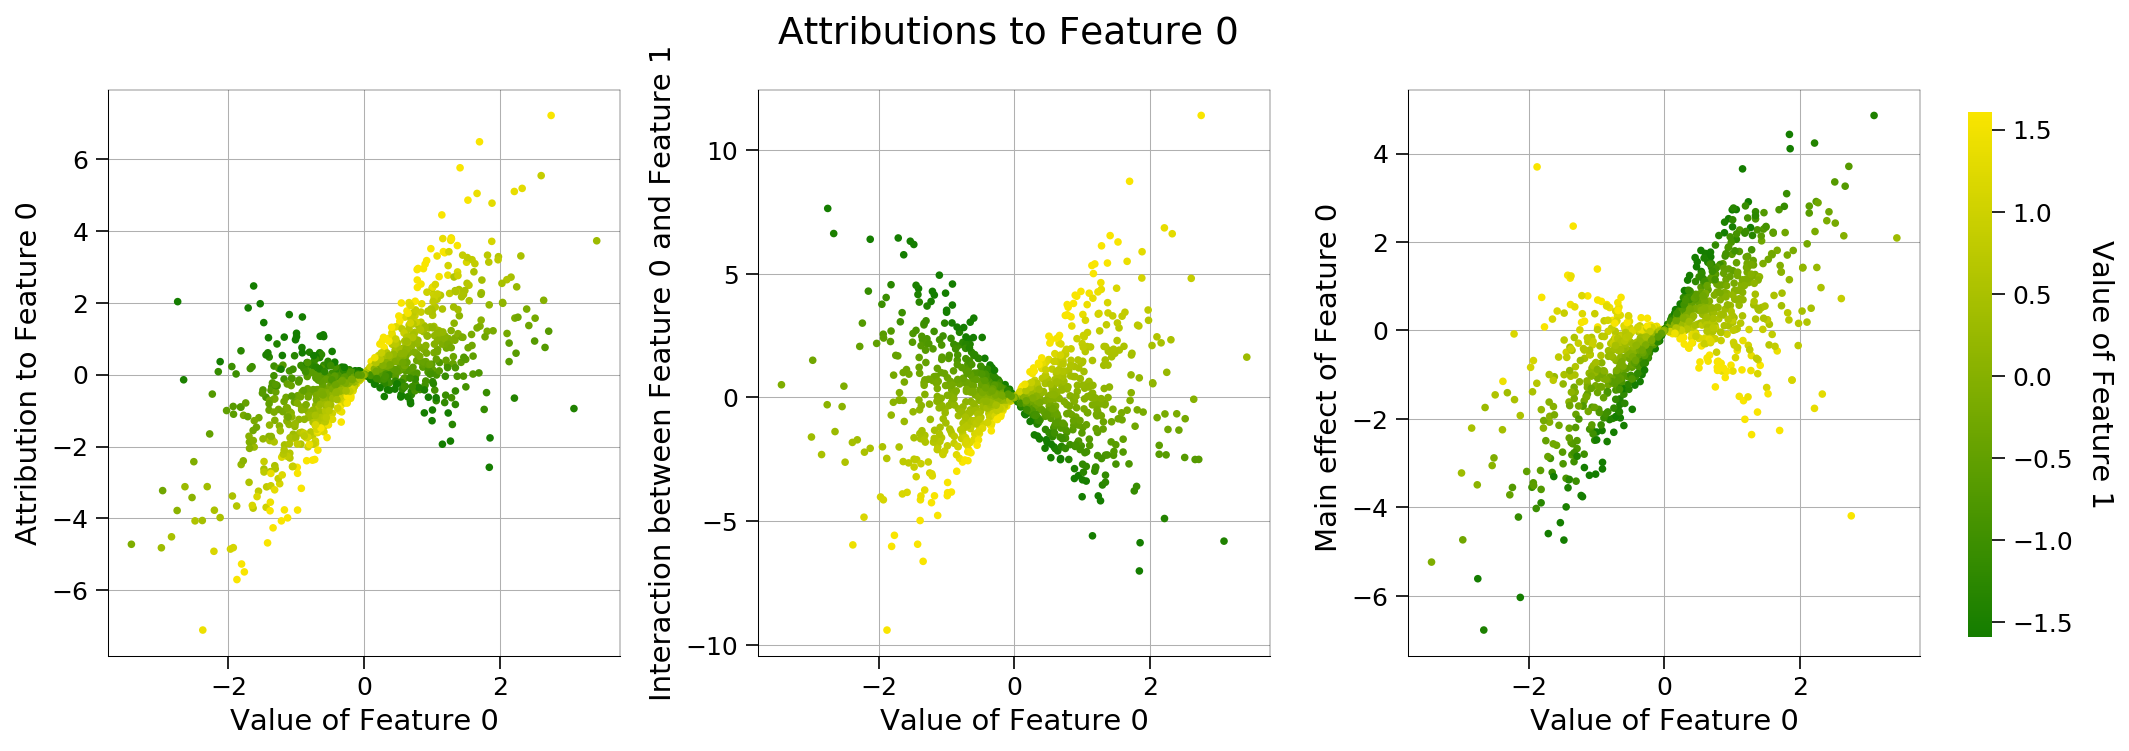

In [21]:
fig, axs = scatter_plot(attributions,
                        feature_values,
                        feature_index=0,
                        interactions=interactions * 0.5,
                        color_by=1,
                        feature_names=None,
                        scale_y_ind=True)

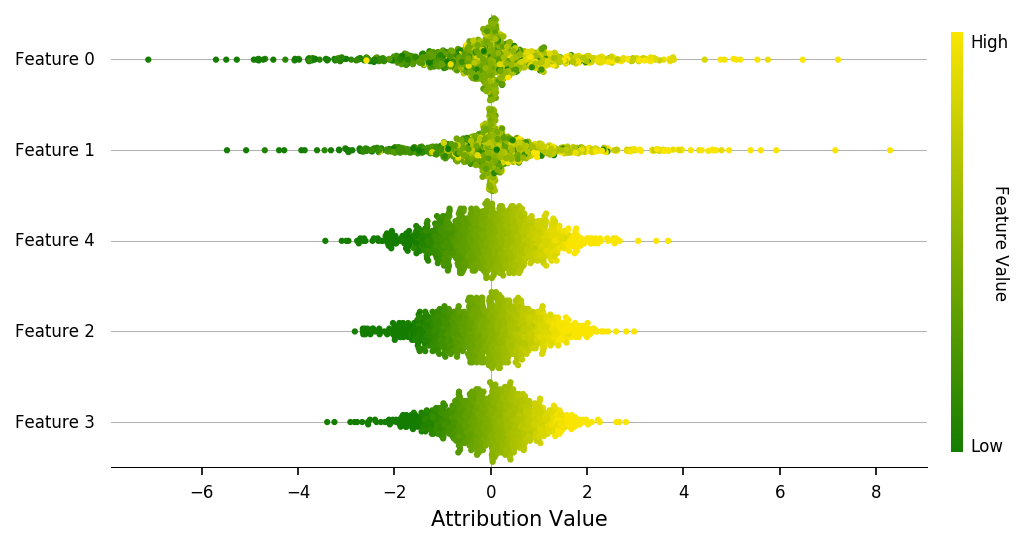

In [22]:
summary_plot(attributions,
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)

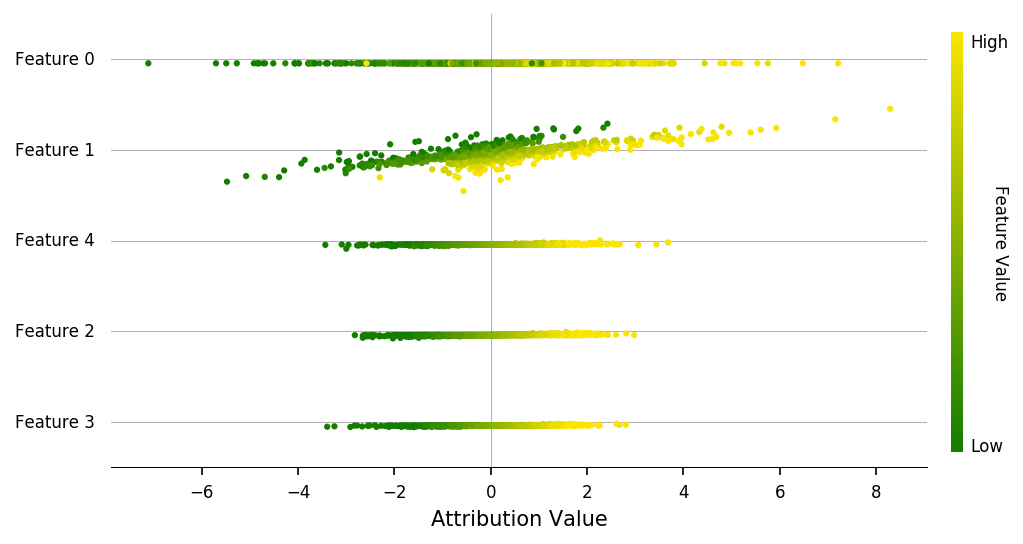

In [23]:
summary_plot(attributions,
             feature_values,
             interactions=interactions,
             interaction_feature=0,
             feature_names=None,
             plot_top_k=None)